## Importing Data

In [187]:
import pandas as pd

cols = ["Origin", "Destination", "Origin City", "Destination City", "Passengers", "Seats", "Flights",
        "Distance", "Fly Date", "Origin Population", "Destination Population"]
dat = pd.read_csv(r"data/flight_edges.tsv", sep="\t", names=cols)
dat.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population
0,MHK,AMW,"Manhattan, KS","Ames, IA",1,30,1,254.0,200810,122049,86219
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103.0,199011,284093,76034
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103.0,199012,284093,76034
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103.0,199010,284093,76034
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156.0,199002,147300,76034


### Demonstration

In [188]:
dat = dat[dat["Destination"] == "JFK"]
dat.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Fly Date,Origin Population,Destination Population
1666865,IND,JFK,"Indianapolis, IN","New York, NY",2229,2500,25,664.0,199005,1299152,33737966
1666866,IND,JFK,"Indianapolis, IN","New York, NY",270,321,3,664.0,199005,1299152,33737966
1666867,IND,JFK,"Indianapolis, IN","New York, NY",125,142,1,664.0,199005,1299152,33737966
1666870,IND,JFK,"Indianapolis, IN","New York, NY",71,107,1,664.0,199003,1299152,33737966
1666871,IND,JFK,"Indianapolis, IN","New York, NY",35,145,1,664.0,199008,1299152,33737966


### Indexing based on datetime objects

In [189]:
dat["Fly Date"] = pd.to_datetime(dat["Fly Date"], format="%Y%m")
dat.set_index("Fly Date", inplace=True)
dat = dat.sort_index()
dat.head()

,Origin,Destination,Origin City,Destination City,Passengers,Seats,Flights,Distance,Origin Population,Destination Population
Fly Date,,,,,,,,,,
1990-01-01,STL,JFK,"St. Louis, MO","New York, NY",37,115,1,892.0,2584656,33737966
1990-01-01,SFO,JFK,"San Francisco, CA","New York, NY",1501,1944,10,2586.0,7436126,33737966
1990-01-01,SFO,JFK,"San Francisco, CA","New York, NY",3388,7830,27,2586.0,7436126,33737966
1990-01-01,SFO,JFK,"San Francisco, CA","New York, NY",151,215,1,2586.0,7436126,33737966
1990-01-01,SFO,JFK,"San Francisco, CA","New York, NY",6195,15145,37,2586.0,7436126,33737966


## Cleaning the Data
### Summing together quantitative variables

In [190]:
dat = dat[["Passengers", "Seats", "Flights"]].groupby(dat.index).sum()
dat.head(12)

,Passengers,Seats,Flights
Fly Date,,,
1990-01-01,397616,756546,4154
1990-02-01,343646,667512,3686
1990-03-01,430448,735481,4092
1990-04-01,431184,681137,3769
1990-05-01,477280,742013,3954
1990-06-01,498790,744732,3991
1990-07-01,513745,806391,4281
1990-08-01,576025,808745,4289
1990-09-01,457128,735307,3886


### Demonstration

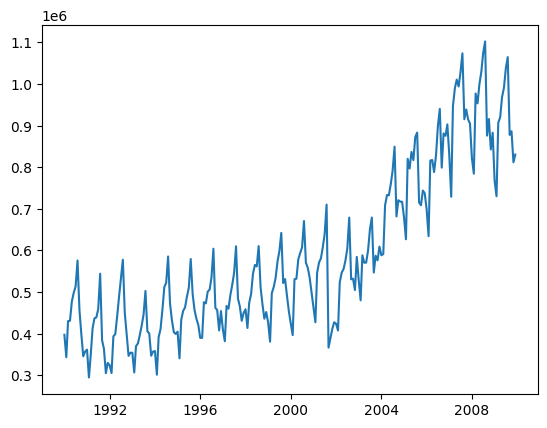

In [191]:
from matplotlib import pyplot as plt
plt.plot(dat["Passengers"])
plt.show()

## Time Series Splits

In [192]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
class seriesSplits:
    def __init__(self, dat):
        self.test = {}
        self.train = {}
        self.dat = dat
        self.models = []
        self.performance = {}
        
    def split(self, testStart, trainStart):
        #Splits until a year, that year is included in the test set
        self.test[(trainStart, testStart)] = self.dat[testStart:].drop(["Flights", "Seats"], axis=1)
        self.train[(trainStart, testStart)] = self.dat[trainStart:str(int(testStart) - 1)].drop(["Flights", "Seats"], axis=1)
    
    def show(self, testStart, trainStart= '1990', *, metrics=False):
        if (trainStart, testStart) not in self.test:
            self.split(testStart, trainStart)
        if len(self.models) != 0:
            figure, axis = plt.subplots(1, len(self.models))
            for index, i in enumerate(self.models):
                plt.figure(index+1)
                plt.subplot(111)
                plt.plot(self.train[(trainStart, testStart)], label = "Training Data")
                plt.plot(self.test[(trainStart, testStart)], label = "Test Data")
                plt.plot(pred := i.forecast(self.train[(trainStart, testStart)], self.test[(trainStart, testStart)]), label="Model Forecast")
                r2, mse, mae = self.metric(self.test[(trainStart, testStart)], pred)
                if (trainStart, testStart, i.title) not in self.performance:
                    self.performance[(trainStart, testStart, i.title)] = (r2, mse, mae)
                if metrics:
                    plt.text(10, 10, "R2=" + str(r2) + "\nMSE=" + str(mse) + "\nMAE=" + str(mae), fontsize = 10)
                plt.title(i.title)
                plt.legend()
        
        else:
            plt.figure(1)
            plt.plot(self.train[(trainStart, testStart)], label = "Training Data")
            plt.plot(self.test[(trainStart, testStart)], label = "Test Data")
            plt.title("Training from " + trainStart + "-" + testStart)
            plt.legend()
        plt.show()
        
    def addModel(self, model):
        self.models.append(model)

    def metric(self, true, pred):
        r2 = r2_score(true, pred)
        mse = mean_squared_error(true, pred)
        mae = mean_absolute_error(true, pred)
        return r2, mse, mae
    
y = seriesSplits(dat)

### Demonstration

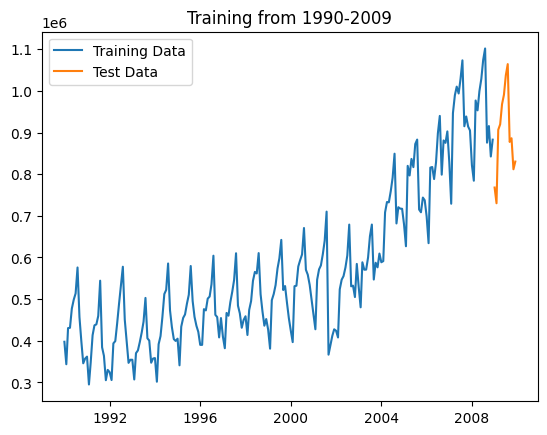

In [193]:
y.show('2009')

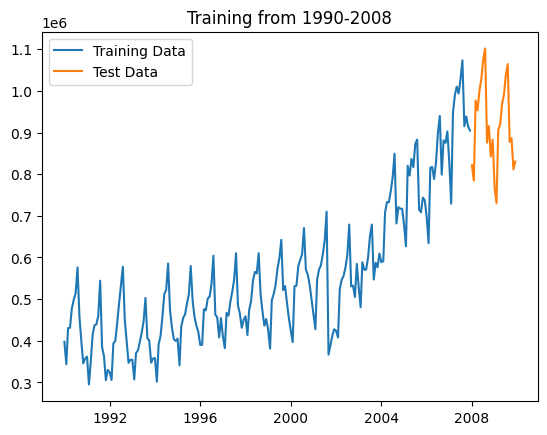

In [194]:
y.show('2008')

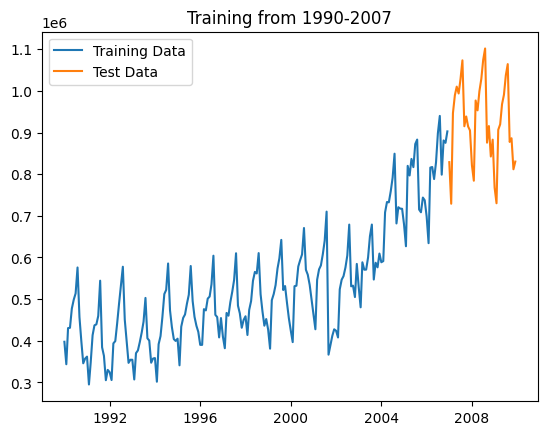

In [195]:
y.show('2007')

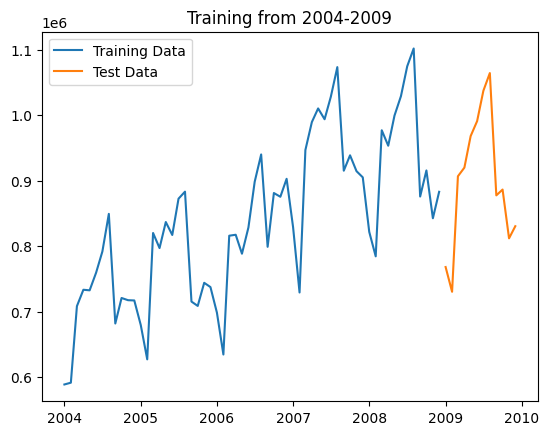

In [196]:
y.show('2009', '2004')

## Models

In [197]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA

import numpy as np
class modelClass:
    def __init__(self, model, title, kwargs, ts=None):
        self.title = title
        self.model = model
        self.kwargs = kwargs 
        self.ts = ts
        if ts != None:
            self.ts.addModel(self)
    
    def forecast(self, train, test):
        fore = test.copy()
        fore["forecast"] = self.model(np.asarray(train["Passengers"]), **self.kwargs).fit().forecast(len(test))
        return fore["forecast"]

modelClass(SimpleExpSmoothing, "Simple Exponential Smoothing", {}, y)
modelClass(ExponentialSmoothing, "Holt Exponential Smoothing", {"trend":"add"}, y)
modelClass(ExponentialSmoothing, "Holt-Winters Exponential Smoothing", {"trend":"add", "seasonal":"add", "seasonal_periods":12}, y)
modelClass(ETSModel, "ETS Exponential Smoothing", {"trend":"add", "seasonal":"add", "error":"add", "seasonal_periods":12}, y)
modelClass(ARIMA, "ARIMA", {"order":(12,1,12)}, y)
modelClass(ARIMA, "SARIMA", {"order":(2,1,2), "seasonal_order":(2,1,2,12)}, y)

### Demonstration

C:\Users\Dow\AppData\Local\Temp\ipykernel_24620\88692306.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(111)
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XL

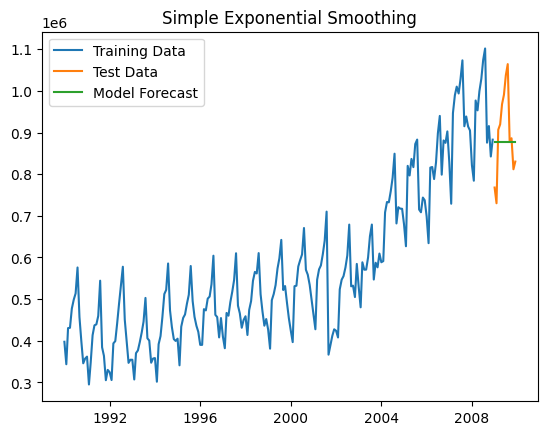

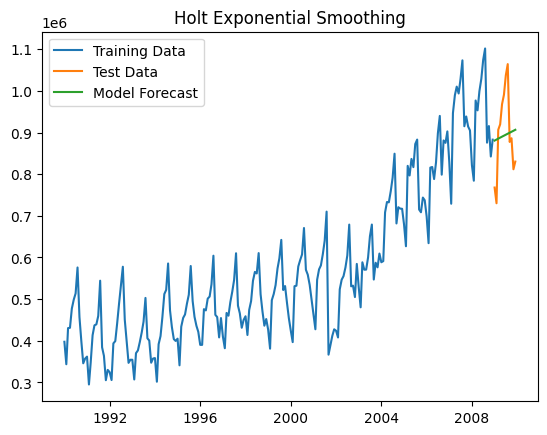

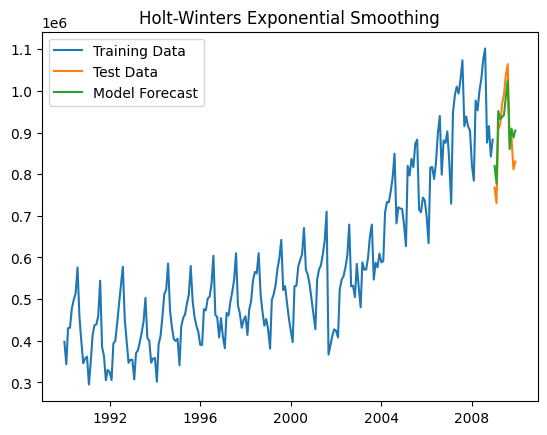

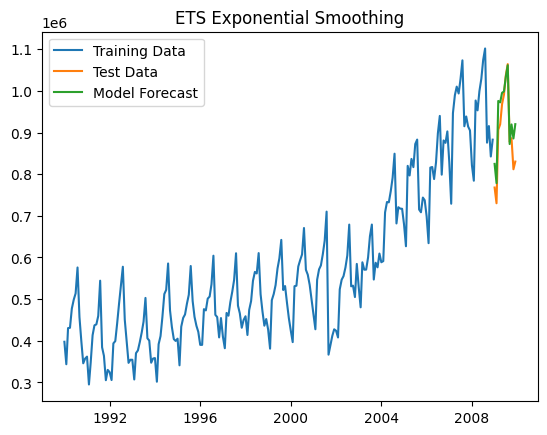

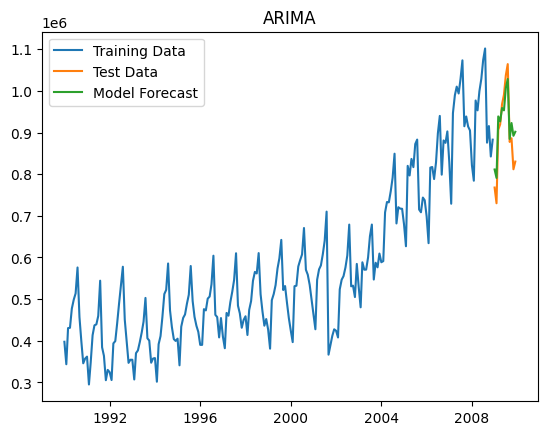

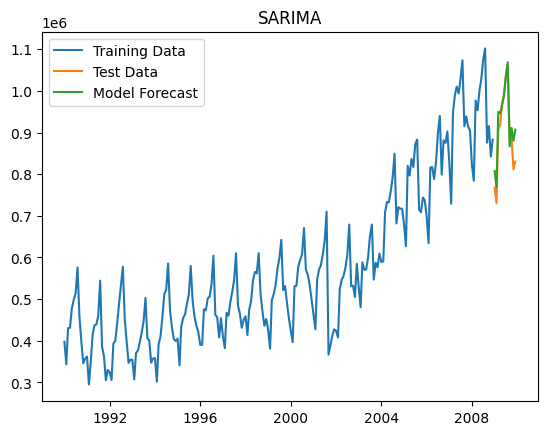

In [198]:
y.show('2009')

C:\Users\Dow\AppData\Local\Temp\ipykernel_24620\88692306.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(111)
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XL

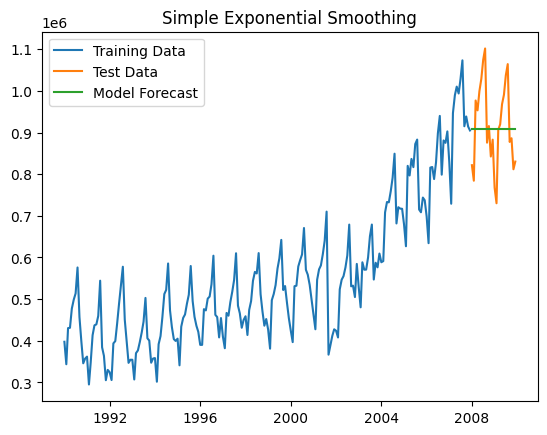

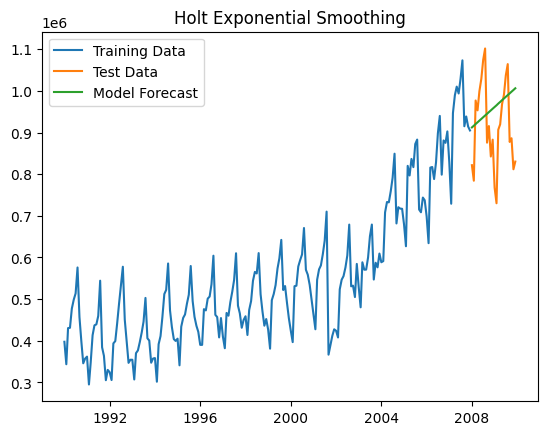

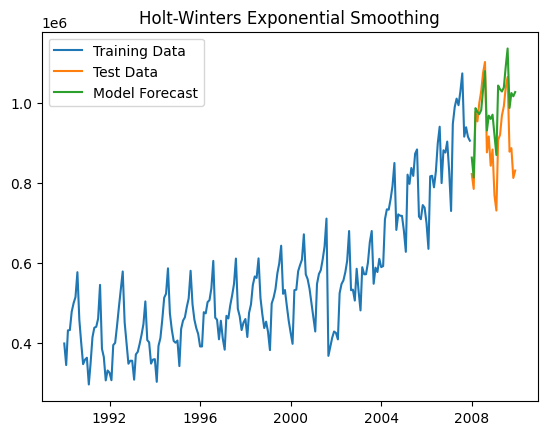

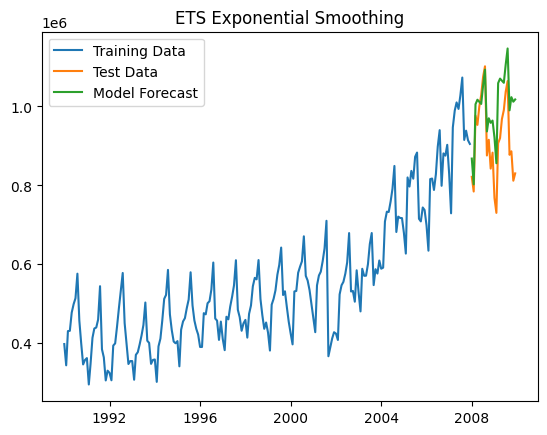

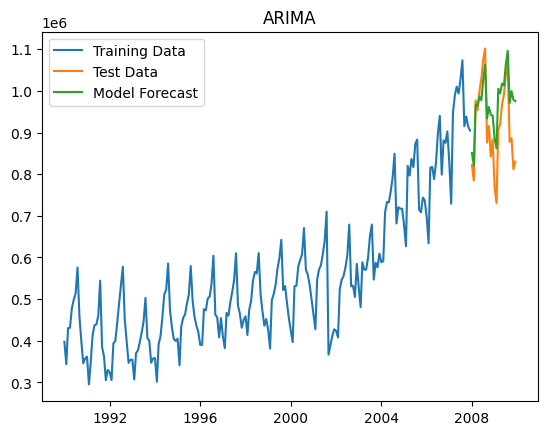

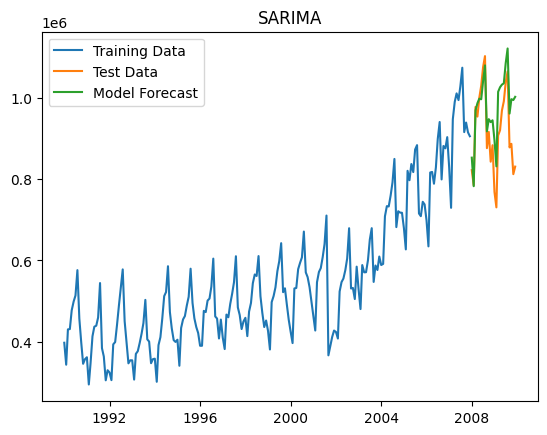

In [199]:
y.show('2008')

C:\Users\Dow\AppData\Local\Temp\ipykernel_24620\88692306.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(111)
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XL

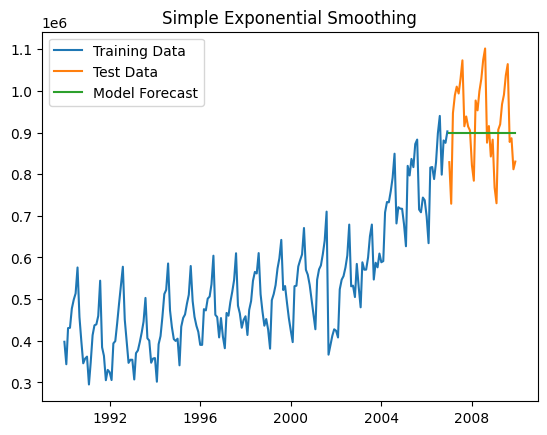

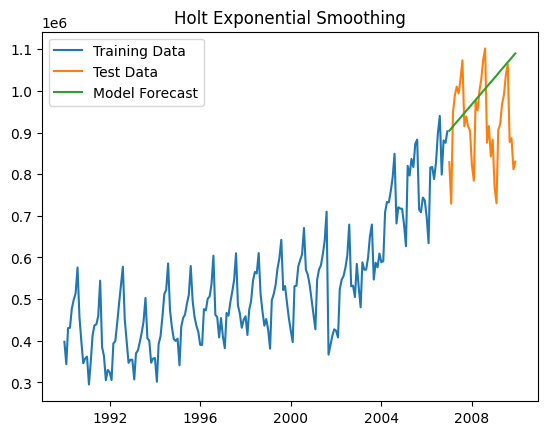

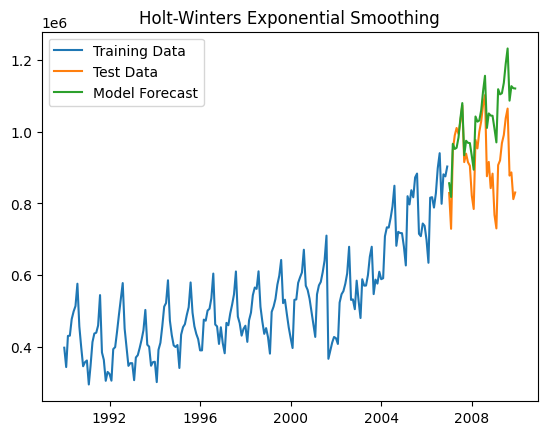

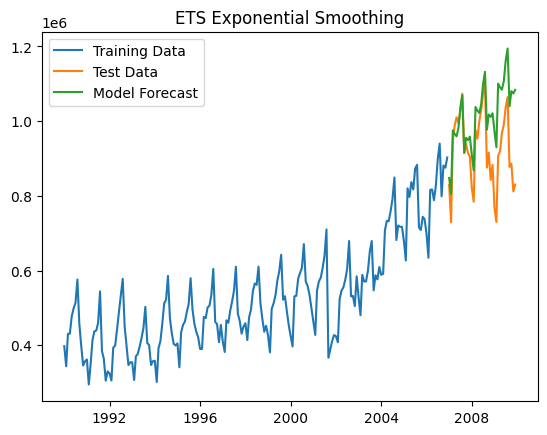

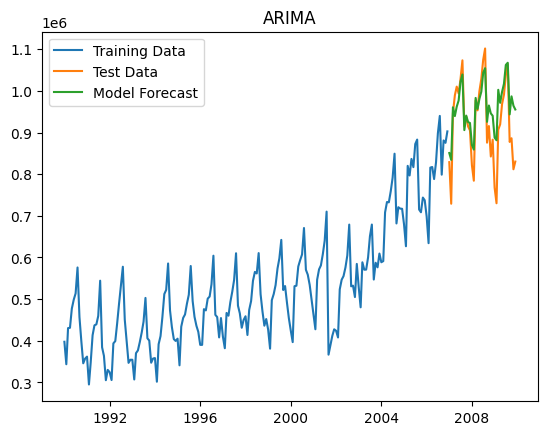

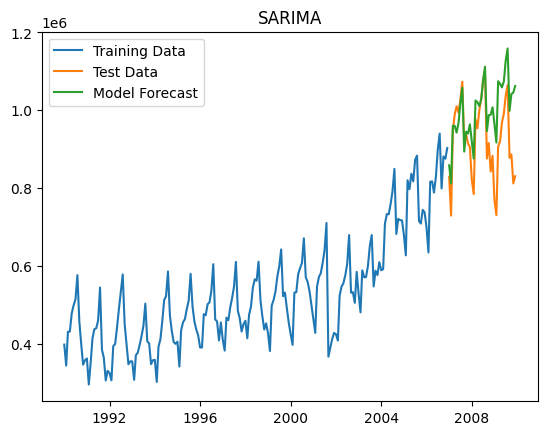

In [200]:
y.show('2007')

C:\Users\Dow\AppData\Local\Temp\ipykernel_24620\88692306.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(111)
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XL

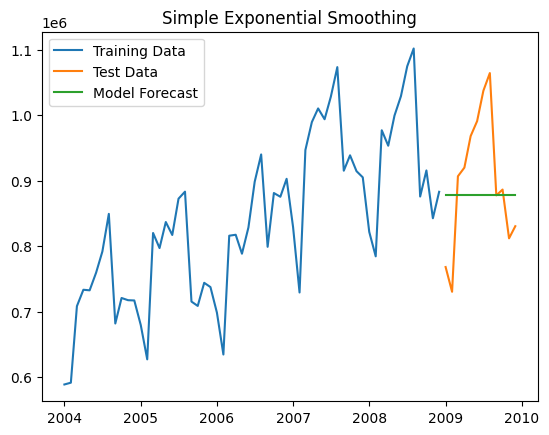

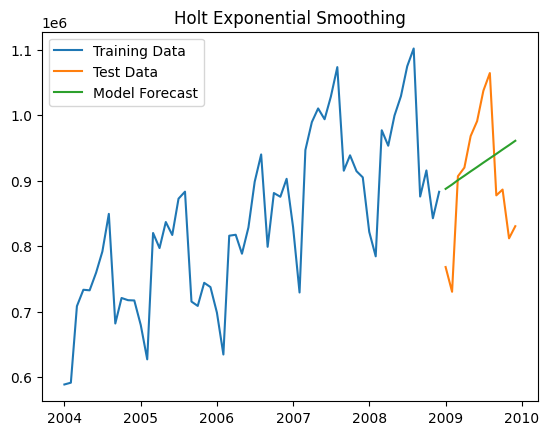

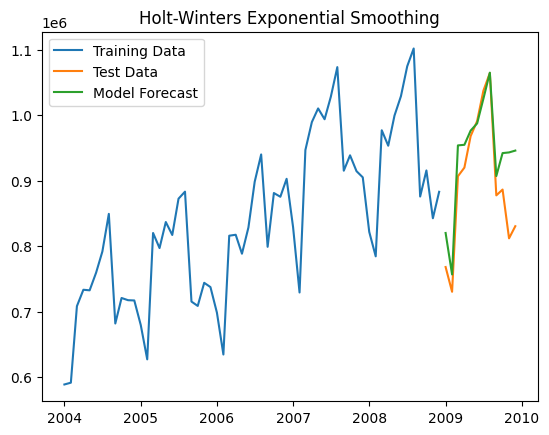

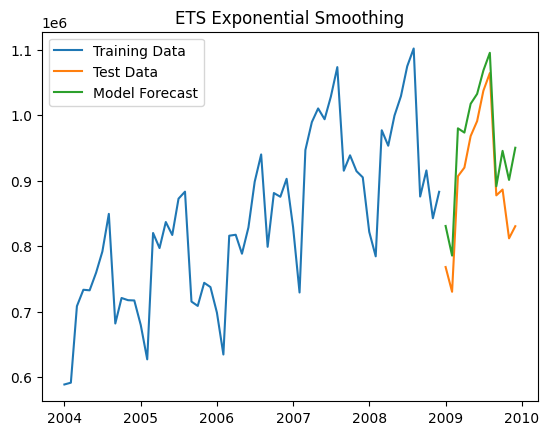

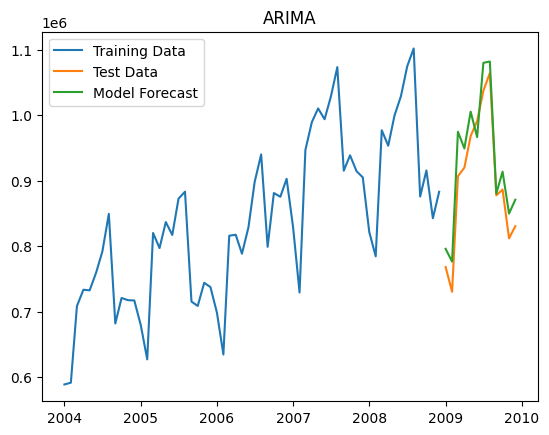

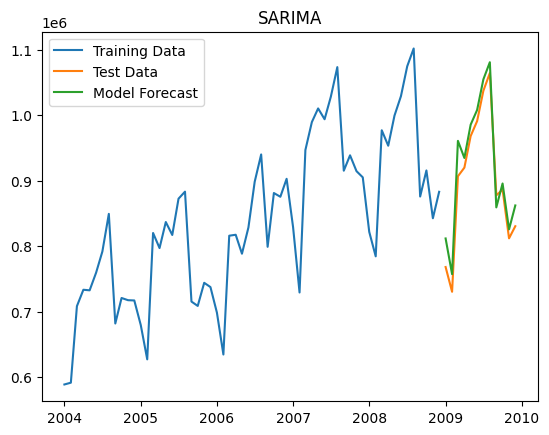

In [201]:
y.show('2009', '2004')

## Metrics
### Demonstration

C:\Users\Dow\AppData\Local\Temp\ipykernel_24620\88692306.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(111)
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XLovyRyR-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Dow\AppData\Local\pypoetry\Cache\virtualenvs\flights-XL

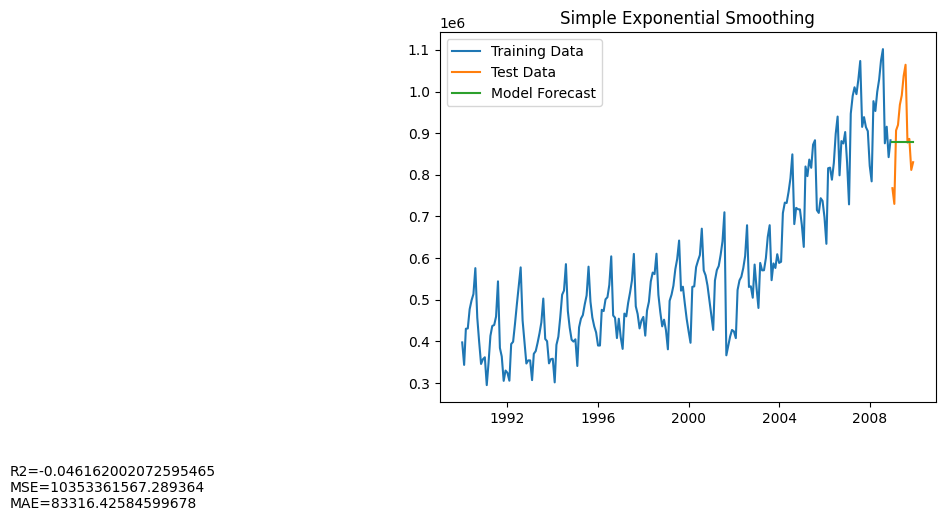

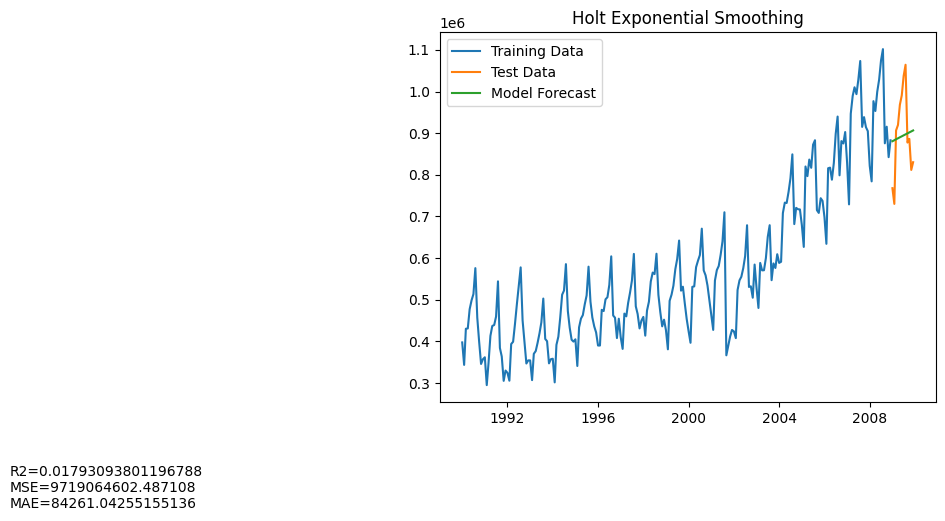

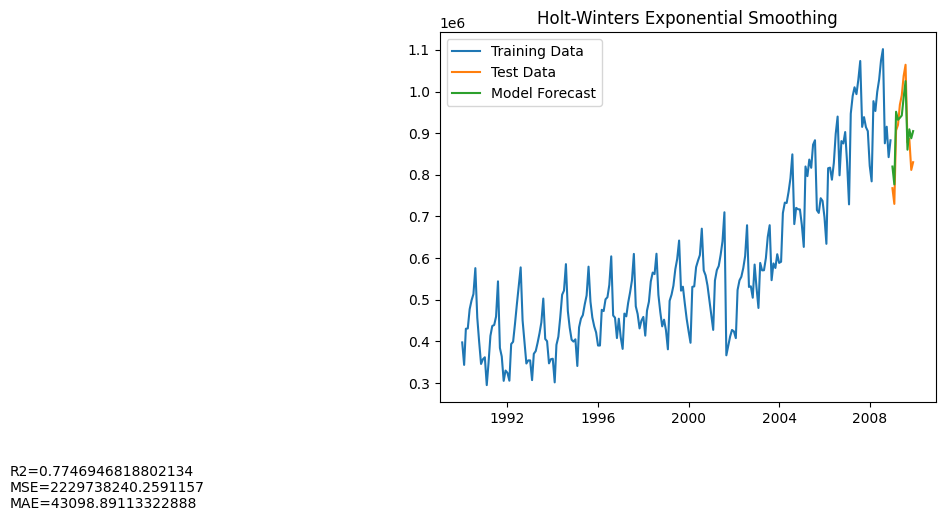

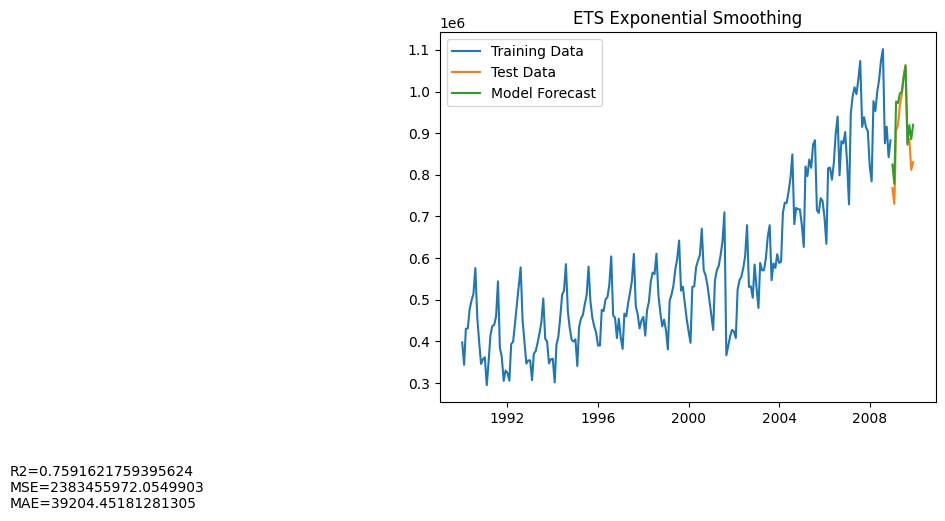

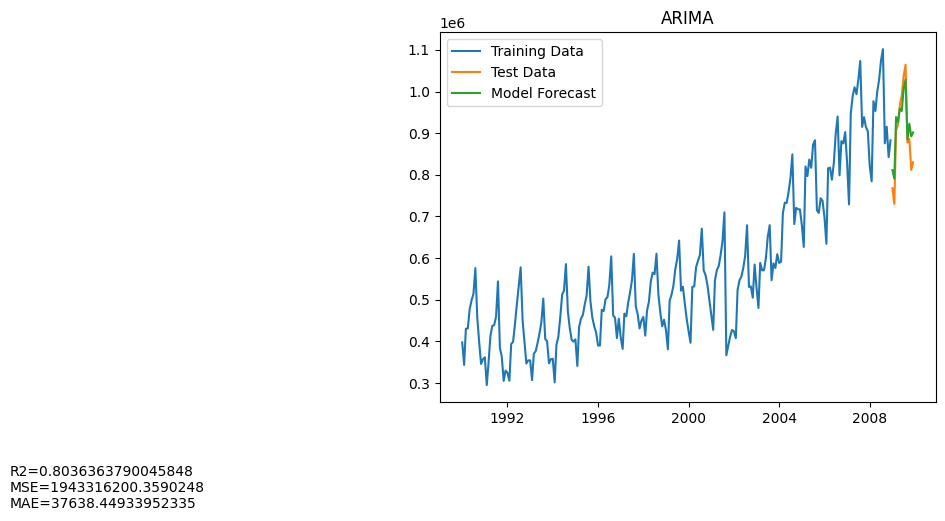

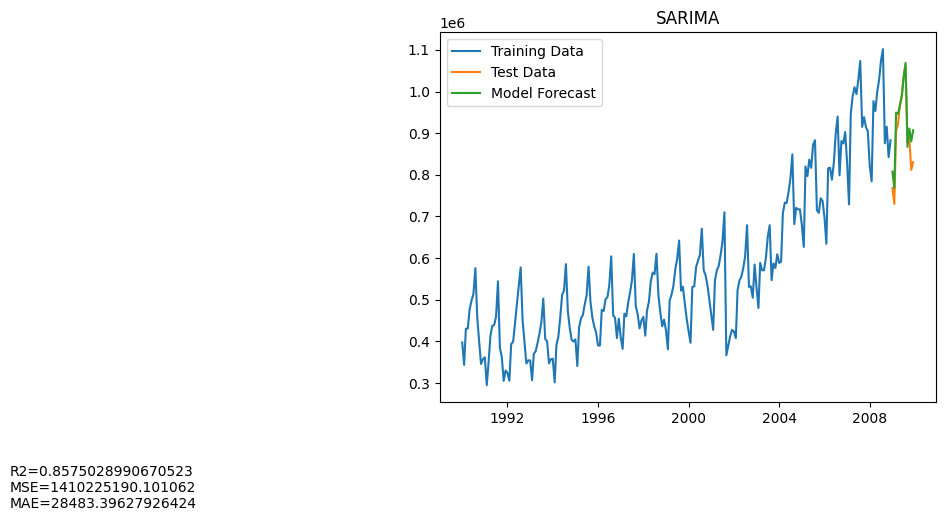

In [202]:
y.show("2009", metrics=True)

In [203]:
y.performance

{('1990', '2009', 'Simple Exponential Smoothing'): (-0.046162002072595465,
  10353361567.289364,
  83316.42584599678),
 ('1990', '2009', 'Holt Exponential Smoothing'): (0.01793093801196788,
  9719064602.487108,
  84261.04255155136),
 ('1990', '2009', 'Holt-Winters Exponential Smoothing'): (0.7746946818802134,
  2229738240.2591157,
  43098.89113322888),
 ('1990', '2009', 'ETS Exponential Smoothing'): (0.7591621759395624,
  2383455972.0549903,
  39204.45181281305),
 ('1990', '2009', 'ARIMA'): (0.8036363790045848,
  1943316200.3590248,
  37638.44933952335),
 ('1990', '2009', 'SARIMA'): (0.8575028990670523,
  1410225190.101062,
  28483.39627926424),
 ('1990', '2008', 'Simple Exponential Smoothing'): (-0.01265054355005768,
  10163081261.552729,
  83887.83333333333),
 ('1990', '2008', 'Holt Exponential Smoothing'): (-0.3025038638256152,
  13072083648.066277,
  97747.58768603958),
 ('1990', '2008', 'Holt-Winters Exponential Smoothing'): (0.028061531632871284,
  9754490034.25725,
  82197.89323